In [1]:
import pandas as pd
import numpy as np
import os


# Extrair dados

In [3]:
# Função para ler instância personalizada de MDVRP conforme o formato especificado
def read_mdvrp_instance(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Primeira linha: tipo de problema, número de veículos, número de clientes, número de depósitos
    problem_type, m, n, t = map(int, lines[0].split())
    
    # Dados dos depósitos
    depots = []
    for i in range(1, t + 1):
        D, Q = map(int, lines[i].split())
        depots.append({'max_duration': D, 'max_load': Q})
    
    # Dados dos clientes
    customers = []
    for i in range(t + 1, len(lines)):
        data = list(map(int, lines[i].split()))
        customer = {
            'id': data[0],
            'x': data[1],
            'y': data[2],
            'service_duration': data[3],
            'demand': data[4],
            'frequency': data[5],
            'num_combinations': data[6],
            'visit_combinations': data[7:7 + data[6]],
            'time_window_start': data[-2] if len(data) > 7 + data[6] else None,
            'time_window_end': data[-1] if len(data) > 7 + data[6] else None,
        }
        customers.append(customer)
    
    # Lista os últimos t depósitos e adiciona os atributos `x` e `y` a cada depósito
    for depot, customer in zip(depots, customers[-t:]):
        depot.update({'x': customer['x'], 'y': customer['y']})

    #return problem_type, m, n, t, depots, customers
    return {'type': problem_type, 'num_vehicles': m, 'num_customers': n, 'num_depots': t, 'depots': depots, 'customers': customers}

In [4]:
INSTANCES_DIR = r'../datasets/C-mdvrp'
files = os.listdir(INSTANCES_DIR)

In [5]:
instances = []
for instance in files:
    try:
        data = read_mdvrp_instance(f'{INSTANCES_DIR}/{instance}')
        
        data_depots = data['depots']
        loads = [depot['max_load'] for depot in data_depots]

        data.update({'filename': instance, 'max_depot_vehicles_load': max(loads)})
    except:
        data = []
        print(f'Error on file number: {instance}')

    instances.append(data)

In [39]:
locations = {}
for customer in instances[0]['customers']:
    locations[customer['id']] = ({'id': customer['id'], 'x': customer['x'], 'y': customer['y']})

In [40]:
locations

{1: {'id': 1, 'x': 37, 'y': 52},
 2: {'id': 2, 'x': 49, 'y': 49},
 3: {'id': 3, 'x': 52, 'y': 64},
 4: {'id': 4, 'x': 20, 'y': 26},
 5: {'id': 5, 'x': 40, 'y': 30},
 6: {'id': 6, 'x': 21, 'y': 47},
 7: {'id': 7, 'x': 17, 'y': 63},
 8: {'id': 8, 'x': 31, 'y': 62},
 9: {'id': 9, 'x': 52, 'y': 33},
 10: {'id': 10, 'x': 51, 'y': 21},
 11: {'id': 11, 'x': 42, 'y': 41},
 12: {'id': 12, 'x': 31, 'y': 32},
 13: {'id': 13, 'x': 5, 'y': 25},
 14: {'id': 14, 'x': 12, 'y': 42},
 15: {'id': 15, 'x': 36, 'y': 16},
 16: {'id': 16, 'x': 52, 'y': 41},
 17: {'id': 17, 'x': 27, 'y': 23},
 18: {'id': 18, 'x': 17, 'y': 33},
 19: {'id': 19, 'x': 13, 'y': 13},
 20: {'id': 20, 'x': 57, 'y': 58},
 21: {'id': 21, 'x': 62, 'y': 42},
 22: {'id': 22, 'x': 42, 'y': 57},
 23: {'id': 23, 'x': 16, 'y': 57},
 24: {'id': 24, 'x': 8, 'y': 52},
 25: {'id': 25, 'x': 7, 'y': 38},
 26: {'id': 26, 'x': 27, 'y': 68},
 27: {'id': 27, 'x': 30, 'y': 48},
 28: {'id': 28, 'x': 43, 'y': 67},
 29: {'id': 29, 'x': 58, 'y': 48},
 30: {

# Gráficos

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [7]:
instances_names = [instance['filename'] for instance in instances]
num_depots = [instance['num_depots'] for instance in instances]
num_vehicles = [instance['num_vehicles'] for instance in instances]
num_customers = [instance['num_customers'] for instance in instances]
max_loads = [instance['max_depot_vehicles_load'] for instance in instances]

In [8]:
# Combine into a DataFrame
data = pd.DataFrame({
    'Name': instances_names,
    'Vehicles': num_vehicles,
    'Depots': num_depots,
    'Customers': num_customers,
    'Max-Load': max_loads
})

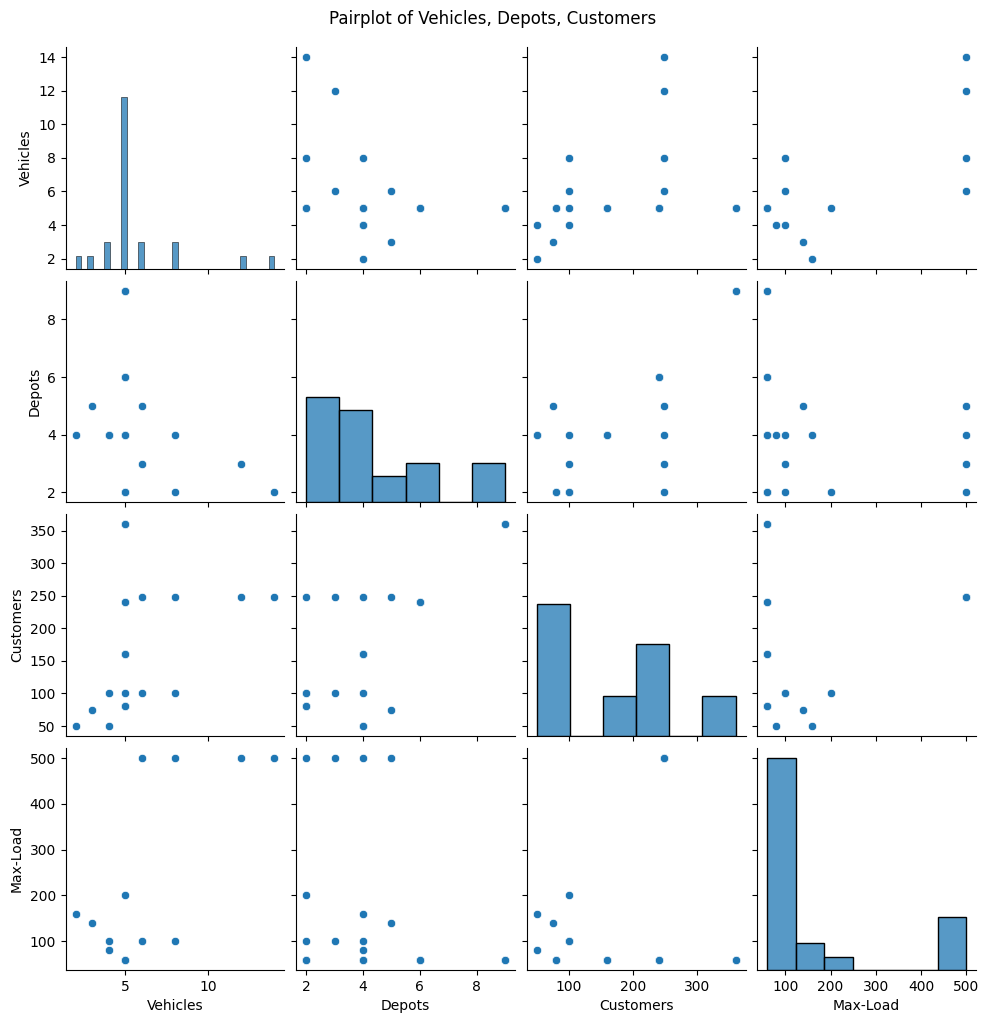

In [298]:
# Scatter plot for each pair of fields with color-coded difficulty
sns.pairplot(data, markers=["o", "s", "D"])
plt.suptitle('Pairplot of Vehicles, Depots, Customers', y=1.02)
plt.show()

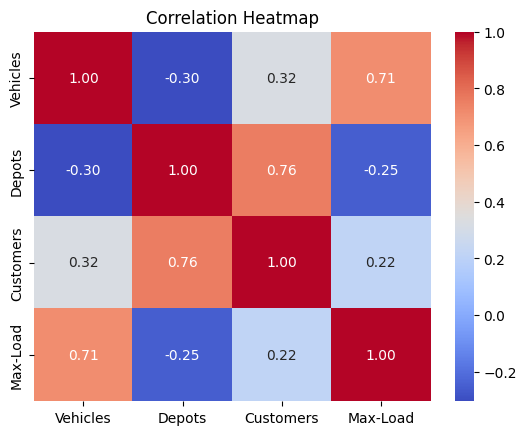

In [299]:
# 1. Heatmap
corr = data[['Vehicles', 'Depots', 'Customers', 'Max-Load']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

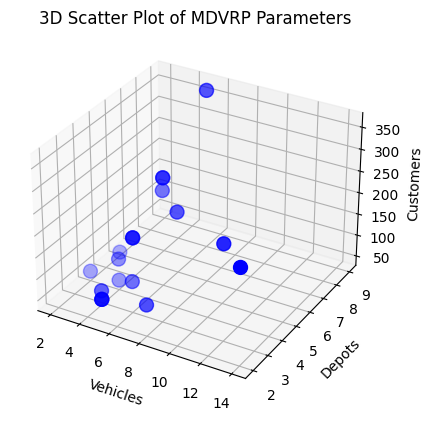

In [300]:
# 2. 3D Scatter Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['Vehicles'], data['Depots'], data['Customers'], s=100, c='blue')
ax.set_xlabel('Vehicles')
ax.set_ylabel('Depots')
ax.set_zlabel('Customers')
plt.title('3D Scatter Plot of MDVRP Parameters')
plt.show()

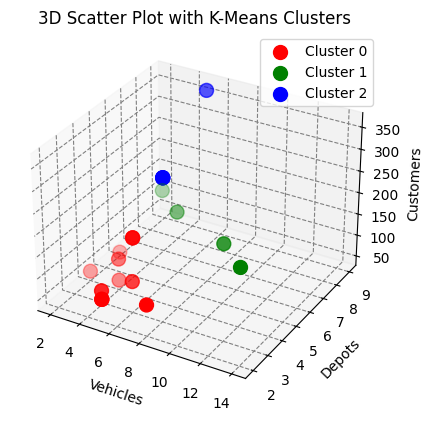

In [301]:
# 3. Apply K-Means Clustering to find natural groupings
kmeans = KMeans(n_clusters=3, random_state=23, algorithm='lloyd')  # Assuming we want to divide into 3 groups: Easy, Medium, Hard
data['Cluster'] = kmeans.fit_predict(data[['Vehicles', 'Depots', 'Customers', 'Max-Load']])


# 4. Plot Clusters in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue']
for cluster in np.unique(data['Cluster']):
    subset = data[data['Cluster'] == cluster]
    ax.scatter(subset['Vehicles'], subset['Depots'], subset['Customers'], s=100, c=colors[cluster], label=f'Cluster {cluster}')

ax.set_xlabel('Vehicles')
ax.set_ylabel('Depots')
ax.set_zlabel('Customers')
plt.title('3D Scatter Plot with K-Means Clusters')

# Add grid lines on all axes
ax.xaxis._axinfo['grid'].update(color = 'grey', linestyle = '--')
ax.yaxis._axinfo['grid'].update(color = 'grey', linestyle = '--')
ax.zaxis._axinfo['grid'].update(color = 'grey', linestyle = '--')

plt.legend()
plt.show()

In [307]:
data.sort_values(by=['Cluster', 'Customers'])

,Name,Vehicles,Depots,Customers,Max-Load,Cluster
0,p01,4,4,50,80,0
1,p02,2,4,50,160,0
2,p03,3,5,75,140,0
11,p12,5,2,80,60,0
12,p13,5,2,80,60,0
13,p14,5,2,80,60,0
3,p04,8,2,100,100,0
4,p05,5,2,100,200,0
5,p06,6,3,100,100,0
6,p07,4,4,100,100,0


In [303]:
data.groupby(by=['Cluster']).count()

,Name,Vehicles,Depots,Customers,Max-Load
Cluster,,,,,
0,13,13,13,13,13
1,4,4,4,4,4
2,6,6,6,6,6


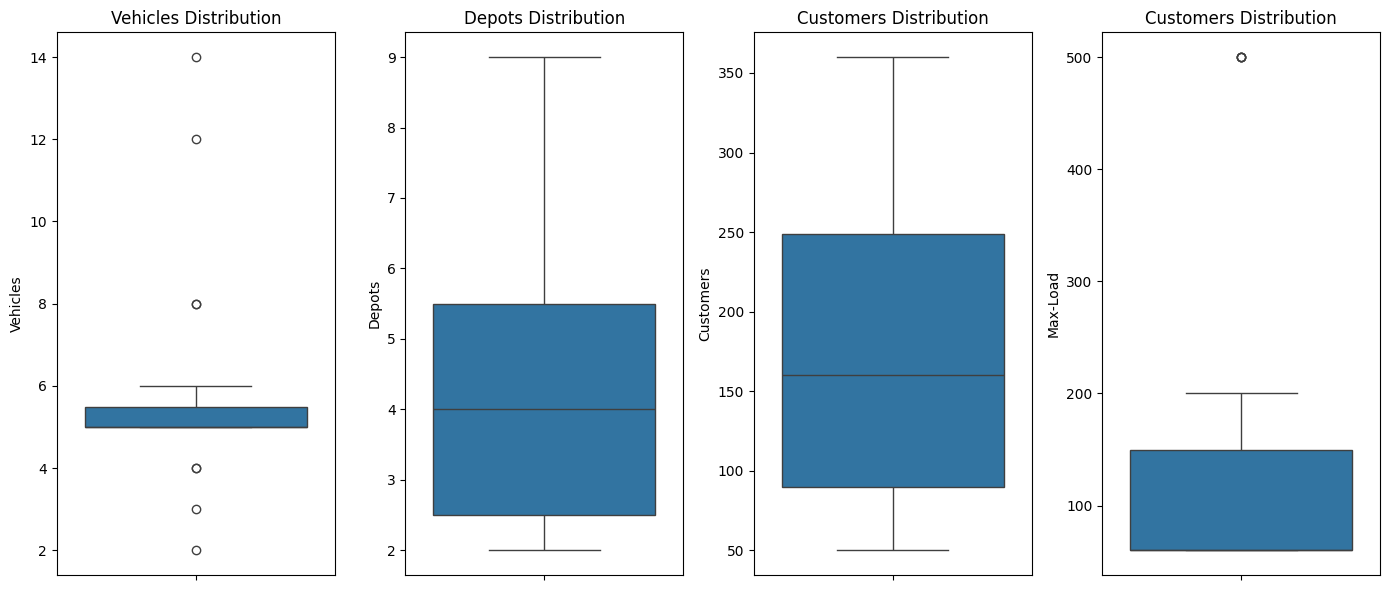

In [304]:
# 5. Boxplot for each variable to help identify thresholds
plt.figure(figsize=(14, 6))

plt.subplot(1, 4, 1)
sns.boxplot(y='Vehicles', data=data)
plt.title('Vehicles Distribution')

plt.subplot(1, 4, 2)
sns.boxplot(y='Depots', data=data)
plt.title('Depots Distribution')

plt.subplot(1, 4, 3)
sns.boxplot(y='Customers', data=data)
plt.title('Customers Distribution')

plt.subplot(1, 4, 4)
sns.boxplot(y='Max-Load', data=data)
plt.title('Customers Distribution')

plt.tight_layout()
plt.show()

## Executar todas as instâncias

In [1]:
import os
from Novo import solve_model

In [2]:
INSTANCES_DIR = r'../datasets/C-mdvrp'
files = os.listdir(INSTANCES_DIR)

In [3]:
for file in files[3:5]:
    print(f'\n********** Instância: {file} **********\n')
    solve_model(f'{INSTANCES_DIR}/{file}')


********** Instância: p04 **********

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-04
Set parameter LazyConstraints to value 1
Set parameter TimeLimit to value 60


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 7535HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 6594 rows, 3296 columns and 19384 nonzeros
Model fingerprint: 0xa88db820
Model has 32 quadratic constraints
Variable types: 64 continuous, 3232 integer (3232 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Presolve removed 3234 rows and 1616 columns
Presolve time: 0.12s
Presolved: 3360 rows, 1680 columns, 9704 nonzeros
Variable types: 64 continuous, 1616 integer (1616 binary)
Found heuristic solution: objective 1586.0000000
Found heuristic solution: objective 1474.0000000
Found heuristic solution: objective 1472.0000000

Root relaxation: objective 8.993443e+01, 3142 itera

# Toy Problem

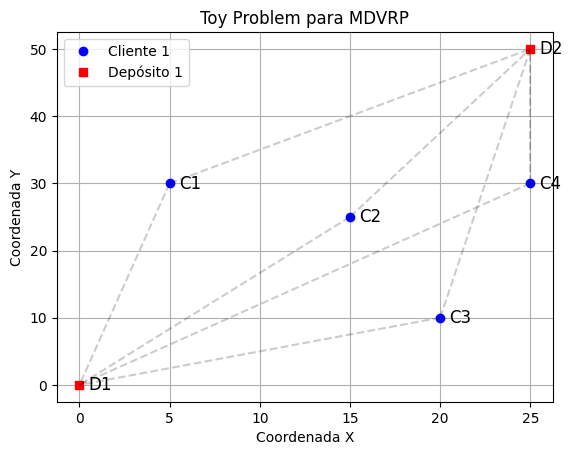

In [7]:
import matplotlib.pyplot as plt

# Coordenadas dos clientes e depósitos
clientes = {
    1: (5, 30),
    2: (15, 25),
    3: (20, 10),
    4: (25, 30)
}

depositos = {
    5: (0, 0),
    6: (25, 50)
}

# Plotando os clientes
for i, coord in clientes.items():
    plt.plot(coord[0], coord[1], 'bo', label=f'Cliente {i}' if i == 1 else "")
    plt.text(coord[0] + 0.5, coord[1], f'C{i}', fontsize=12, verticalalignment='center')

# Plotando os depósitos
for i, coord in depositos.items():
    plt.plot(coord[0], coord[1], 'rs', label=f'Depósito {i - 4}' if i == 5 else "")
    plt.text(coord[0] + 0.5, coord[1], f'D{i-4}', fontsize=12, verticalalignment='center')

# Conectando os clientes aos depósitos (potenciais rotas)
for i, coord in clientes.items():
    # Conectando ao depósito 1
    plt.plot([coord[0], depositos[5][0]], [coord[1], depositos[5][1]], 'k--', alpha=0.2)
    # Conectando ao depósito 2
    plt.plot([coord[0], depositos[6][0]], [coord[1], depositos[6][1]], 'k--', alpha=0.2)

# Configurações adicionais do gráfico
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.legend()
plt.grid(True)
plt.title('Toy Problem para MDVRP')
plt.show()


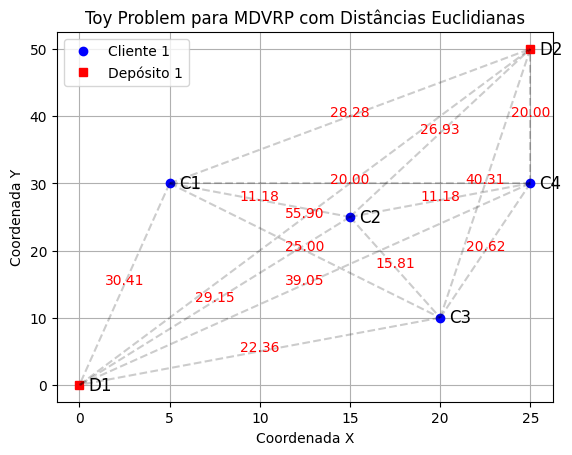

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Função para calcular a distância euclidiana entre dois pontos
def distancia_euclidiana(ponto1, ponto2):
    return np.sqrt((ponto1[0] - ponto2[0]) ** 2 + (ponto1[1] - ponto2[1]) ** 2)

# Coordenadas dos clientes e depósitos
clientes = {
    1: (5, 30),
    2: (15, 25),
    3: (20, 10),
    4: (25, 30)
}

depositos = {
    5: (0, 0),
    6: (25, 50)
}

# Plotando os clientes
for i, coord in clientes.items():
    plt.plot(coord[0], coord[1], 'bo', label=f'Cliente {i}' if i == 1 else "")
    plt.text(coord[0] + 0.5, coord[1], f'C{i}', fontsize=12, verticalalignment='center')

# Plotando os depósitos
for i, coord in depositos.items():
    plt.plot(coord[0], coord[1], 'rs', label=f'Depósito {i - 4}' if i == 5 else "")
    plt.text(coord[0] + 0.5, coord[1], f'D{i-4}', fontsize=12, verticalalignment='center')

# Conectando os pontos e adicionando as distâncias
for i, coord1 in {**clientes, **depositos}.items():
    for j, coord2 in {**clientes, **depositos}.items():
        if i < j:  # Evitar duplicação de linhas (i,j) e (j,i)
            dist = distancia_euclidiana(coord1, coord2)
            plt.plot([coord1[0], coord2[0]], [coord1[1], coord2[1]], 'k--', alpha=0.2)
            mid_x, mid_y = (coord1[0] + coord2[0]) / 2, (coord1[1] + coord2[1]) / 2
            plt.text(mid_x, mid_y, f'{dist:.2f}', fontsize=10, color='red', ha='center')

# Configurações adicionais do gráfico
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.legend()
plt.grid(True)
plt.title('Toy Problem para MDVRP com Distâncias Euclidianas')
plt.show()
